## 1. Install Packages and Libraries

In [5]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [1]:
# Install required packages.
%%capture
import torch
import os
os.environ['TORCH'] = torch.__version__
!pip install torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install pyg-lib -f https://data.pyg.org/whl/nightly/torch-${TORCH}.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git
!pip install surprise

In [2]:
torch.__version__

'2.1.0+cu118'

In [3]:
# import required modules
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
from sklearn.model_selection import train_test_split
from tqdm import tqdm




from torch import Tensor, nn, optim
from torch_geometric.data import download_url, extract_zip
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.nn.conv.gcn_conv import gcn_norm
from torch_geometric.utils import structured_negative_sampling
from torch_sparse import SparseTensor, matmul


Initially, I experimented with Singular Value Decomposition (SVD) and achieved satisfactory results. However, I encountered a limitation with the SVD() method, as it does not incorporate user-specific information into its predictions.

In [18]:
import pandas as pd
from surprise import Reader, Dataset
from surprise.model_selection import train_test_split
from surprise import SVD
from sklearn.metrics import mean_squared_error

# Load user data
user_data = pd.read_csv("/content/u.user", sep="|")
user_data.columns = ['user_id', 'age', 'gender', 'profession', 'zip code']
user_data = user_data.sort_values(by=['user_id'])

# Load movie data
movie_data = pd.read_csv("/content/u.data", sep="\t")
movie_data.columns = ["user_id", "item_id", "rating",  "timestamp"]
movie_data = movie_data.sort_values(by=['user_id'])

# Merge user and movie data
data = pd.merge(user_data, movie_data, on=["user_id"])

# Create a DataFrame
df = pd.DataFrame(data)

# One-hot encoding for gender and profession
df = pd.get_dummies(df, columns=['gender', 'profession'], drop_first=True)

# Create an instance of the Reader class for the surprise library
reader = Reader(rating_scale=(1, 5))

# Load data in a format understandable by the surprise library
dataset = Dataset.load_from_df(df[['user_id', 'item_id', 'rating']], reader)

# Split the dataset into training and testing sets
trainset, testset = train_test_split(dataset, test_size=0.2, random_state=42)

# Create an SVD model and fit it to the training set
model_svd = SVD(n_factors=50, n_epochs=70, lr_all=0.005, reg_all=0.02)
model_svd.fit(trainset)

# Make predictions on the test set
predictions_svd = model_svd.test(testset)

# Print the first 100 predictions
for i in range(100):
    print("Prediction:", predictions_svd[i].est, "Actual:", predictions_svd[i].r_ui)

# Calculate Mean Squared Error
mse = mean_squared_error([x.est for x in predictions_svd], [pred[2] for pred in testset])

# Print Mean Squared Error
print(f'Mean Squared Error: {mse}')


Prediction: 3.7088695054599152 Actual: 4.0
Prediction: 3.9643571652342695 Actual: 4.0
Prediction: 2.7291989879879894 Actual: 5.0
Prediction: 4.937304546761842 Actual: 3.0
Prediction: 4.065716446370103 Actual: 4.0
Prediction: 2.2767796947685586 Actual: 1.0
Prediction: 3.3200323069780597 Actual: 2.0
Prediction: 2.370693743345134 Actual: 4.0
Prediction: 4.068709769249694 Actual: 5.0
Prediction: 3.2101188364207767 Actual: 4.0
Prediction: 4.930692963573827 Actual: 3.0
Prediction: 2.731465737970146 Actual: 3.0
Prediction: 2.6057241812969694 Actual: 4.0
Prediction: 3.5950613438210026 Actual: 4.0
Prediction: 4.334655591544986 Actual: 5.0
Prediction: 3.33584620247912 Actual: 4.0
Prediction: 4.766261313638658 Actual: 5.0
Prediction: 3.1112539036828393 Actual: 3.0
Prediction: 3.1174448049563788 Actual: 4.0
Prediction: 4.36435079385231 Actual: 4.0
Prediction: 2.4966966645188036 Actual: 1.0
Prediction: 2.058241574965282 Actual: 2.0
Prediction: 4.064451713821244 Actual: 4.0
Prediction: 2.19105706245

Then, i tried LinearRegression(). And result is not so good

In [19]:
import pandas as pd
from sklearn.model_selection import train_test_split
from surprise import SVD
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Create a DataFrame from the data
df = pd.DataFrame(data)

# One-hot encoding for gender and profession
df = pd.get_dummies(df, columns=['gender', 'profession'], drop_first=True)

trainset, test_set = train_test_split(df, test_size=0.2, random_state=42)

# Train a linear regression model on user information (age, gender, profession)
model_user_info = LinearRegression()
df.fillna(0, inplace=True)
df = df.drop(['zip code', 'timestamp'], axis=1)
model_user_info.fit(df.drop(['rating'], axis=1), df['rating'])

# Get predictions from the user information model
user_info_predictions = model_user_info.predict(test_set.drop(['rating', 'timestamp', 'zip code'], axis=1))

# Normalize and scale user_info_predictions to be in the range of 1 to 5
user_info_predictions = ((user_info_predictions - min(user_info_predictions)) / (max(user_info_predictions) - min(user_info_predictions))) * 5


# Evaluate the performance of the hybrid model
mse = mean_squared_error(user_info_predictions, test_set['rating'])
print(f'Mean Squared Error: {mse}')


Mean Squared Error: 1.3697543372966023


# Movie Recommender System based on LightGCN

> that is what i choose




MovieLens 100k is a well-known movie recommendation dataset that contains 100,000 movie ratings from 943 users on 1,682 movies. Each user has rated at least 20 movies on a scale of 1 to 5, and the data is provided in a matrix format where each row represents a user and each column represents a movie. The dataset also includes additional information such as movie genre and release year. MovieLens 100k is often used as a benchmark for evaluating movie recommendation models and algorithms.

In [20]:
# import required modules
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
from sklearn.model_selection import train_test_split
from tqdm import tqdm

import torch
import sys

from torch import Tensor, nn, optim
from torch_geometric.data import download_url, extract_zip
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.nn.conv.gcn_conv import gcn_norm
from torch_geometric.utils import structured_negative_sampling
from torch_sparse import SparseTensor, matmul

In [21]:
# download the dataset
url = 'https://files.grouplens.org/datasets/movielens/ml-latest-small.zip'
extract_zip(download_url(url, '.'), '.')

movie_path = './ml-latest-small/movies.csv'
rating_path = './ml-latest-small/ratings.csv'

Using existing file ml-latest-small.zip
Extracting ./ml-latest-small.zip


The `ratings.csv` dataset links users (identified by `userId`) and movies (identified by `movieId`). Our initial objective is to construct a dictionary that maps each entry's ID to a unique value within the range `{ 0, ..., num_rows - 1 }`. This mapping is beneficial since it reduces the size of the adjacency matrix. We then generate an `edge_index` matrix from `ratings.csv` with dimensions `[2, num_ratings]`. The first row contains the mapped userId, while the second row has the mapped `movieId`. A specific column corresponds to a connection (or rating) between a user and a movie. The `edge_index` tensor is a crucial component for message propagation throughout the graph network.


In [22]:
import pandas as pd
import torch
sys.path.append('/content/drive/MyDrive/Assignment2/data/')
import preprocessing
from preprocessing import *

def preprocessing(movie_path, rating_path):
  '''
    Parameters:
         movie_path (str): A string representing the file path to the movies dataset.
         rating_path (str): A string representing the file path to the ratings dataset.

    Returns:
         edge_index (torch.Tensor): the indices of edges in the adjacency matrix for the ratings dataset.
         num_users (int): number of unique users in the ratings dataset.
         num_movies (int): number of unique movies in the ratings dataset.
         user_mapping (pd.DataFrame): the list that map user id to continguous new ids
         movie_df (pd.DataFrame): the movie dataset
         rating_df (pd.DataFrame): the rating dataset
  '''
  # load movies and ratings dataset
  movie_df = pd.read_csv(movie_path, index_col = 'movieId')
  rating_df = pd.read_csv(rating_path, index_col = 'userId')

  # create mapping to continous range
  movie_mapping = {idx: i for i, idx in enumerate(movie_df.index.unique())}
  user_mapping = {idx: i for i, idx in enumerate(rating_df.index.unique())}
  num_users, num_movies = len(rating_df.index.unique()), len(movie_df.index.unique())

  rating_df = pd.read_csv(rating_path)
  edge_index = None
  users = [user_mapping[idx] for idx in rating_df['userId']]
  movies = [movie_mapping[idx] for idx in rating_df['movieId']]

  # filter for edges with a high rating
  ratings = rating_df['rating'].values
  recommend_bool = torch.from_numpy(ratings).view(-1, 1).to(torch.long) >= 4

  edge_index = [[],[]]
  for i in range(recommend_bool.shape[0]):
    if recommend_bool[i]:
      edge_index[0].append(users[i])
      edge_index[1].append(movies[i])

  edge_index = torch.tensor(edge_index)
  return edge_index, num_users, num_movies, movie_mapping, user_mapping, movie_df, rating_df

In [23]:
edge_index, num_users, num_movies,movie_mapping, user_mapping,movie_df, rating_df = preprocessing(movie_path, rating_path)

### A peek into the MovieLens 100K dataset

Let's take a look into the MovieLens dataset. We can see the `movie.csv` has the following format: `movieId title genres`



In [24]:
# format for movie
movie_df.head(10)

,title,genres
movieId,,
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,Jumanji (1995),Adventure|Children|Fantasy
3,Grumpier Old Men (1995),Comedy|Romance
4,Waiting to Exhale (1995),Comedy|Drama|Romance
5,Father of the Bride Part II (1995),Comedy
6,Heat (1995),Action|Crime|Thriller
7,Sabrina (1995),Comedy|Romance
8,Tom and Huck (1995),Adventure|Children
9,Sudden Death (1995),Action


The `rating.csv` has the following format of `userId, movieId, rating, timestamp`. For the raitng prediction task, we only need the first three fields for the purpose of our task.

In [25]:
# format for ratings
rating_df.head(10)

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
5,1,70,3.0,964982400
6,1,101,5.0,964980868
7,1,110,4.0,964982176
8,1,151,5.0,964984041
9,1,157,5.0,964984100


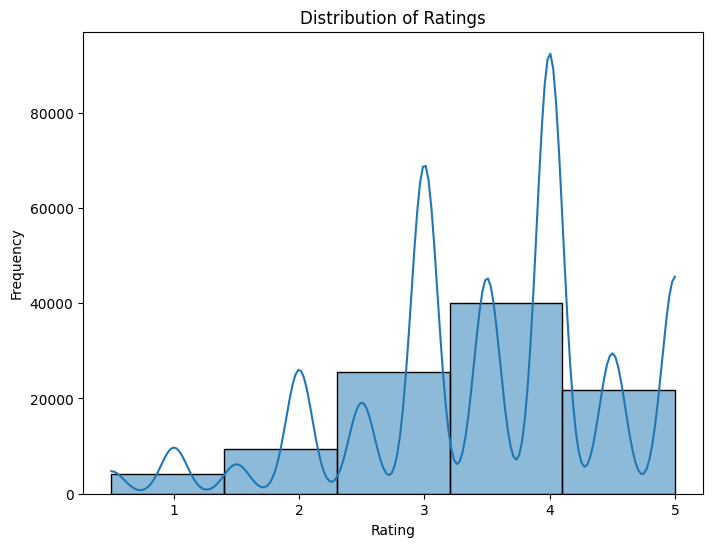

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming rating_df is your DataFrame

# Plot a histogram of ratings
plt.figure(figsize=(8, 6))
sns.histplot(rating_df['rating'], bins=5, kde=True)
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()


We also need to know the rating scales because we need to determine beyond what scores we can say that a user likes the movies.

In [31]:
# what are the ratings
sorted(pd.unique(rating_df['rating']))

[0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]

### Prepare datasets

Next, we divide the complete dataset into training, validation, and testing sets. The partition is made based on the edges in the graph. More specifically, we randomly separate the data into three groups with an 80/10/10 split ratio. This implies that each group will contain a portion of the `edge_index` subset.

In [32]:
# split the edges into train set and test set
num_ratings = edge_index.shape[1]
rating_indices = np.arange(num_ratings)

indices_train, indices_val_test = train_test_split(rating_indices, test_size = 0.2, random_state = 42)
indices_val, indices_test = train_test_split(indices_val_test, test_size = 0.5, random_state = 42)

# slice the whole dataset by split indices, then convert to SparseTensor for later training
def generate_edge(edge_indices):
  '''
  Paramters:
      edge_indices (np.ndarray): An array representing the indices of edges in the dataset.

  Returns:
      sub_edge_index (torch.Tensor): indices of edges in the specified subset.
      edge_index_sparse (SparseTensor): A sparse tensor representing the adjacency matrix for the subset of edges.
  '''
  sub_edge_index = edge_index[:, edge_indices]
  num_nodes = num_users + num_movies
  edge_index_sparse = SparseTensor(row = sub_edge_index[0],
                                   col = sub_edge_index[1],
                                   sparse_sizes = (num_nodes, num_nodes))
  return sub_edge_index, edge_index_sparse

train_edge_index, train_sparse_edge_index = generate_edge(indices_train)
val_edge_index, val_sparse_edge_index = generate_edge(indices_val)
test_edge_index, test_sparse_edge_index = generate_edge(indices_test)

During the training phase, we will use mini-batches and select a number of positive and negative edges within each batch. Positive edges refer to observed or training user-item interactions. We aim to punish negative edges during training by allocating them with a greater loss. To achieve this, we will make use of the PyG function called `structured_negative_sampling,` which selects a negative edge for every positive edge in the graph as defined by `edge_index`.

In [33]:
edges = structured_negative_sampling(train_edge_index)
edges = torch.stack(edges, dim=0)
edges

tensor([[ 408,  579,    2,  ...,  482,   15,  205],
        [ 863,  990, 3734,  ..., 5729,  561,  621],
        [4497, 5117, 7626,  ..., 4613, 4606, 7421]])

In [34]:
def mini_batch_sample(batch_size, edge_index):
    """
    Randomly samples indices of a minibatch given an adjacency matrix.
    These tensors represent the indices of the sampled minibatch, where:
    - user indices: indices of the users in the sampled edges
    - positive item indices: indices of the positive items in the sampled edges
    - negative item indices: indices of the negative items in the sampled edges

    Parameters:
    batch_size (int): The desired minibatch size.
    edge_index (torch.Tensor): A 2 by N tensor representing the edges.

    Returns:
    user indices, positive item indices, negative item indices (torch.Tensor)
    """
    edges = structured_negative_sampling(edge_index)
    edges = torch.stack(edges, dim=0)
    indices = torch.randperm(edges.shape[1])[:batch_size]
    batch = edges[:, indices]
    user_indices, pos_item_indices, neg_item_indices = batch[0], batch[1], batch[2]
    return user_indices, pos_item_indices, neg_item_indices

## 3.Model Architecture


LightGCN is a member of the graph convolutional networks (GCNs) family, designed as a recommender system model. Its main goal is to deliver personalized recommendations by leveraging the structure of the user-item interaction graph. In contrast to other recommendation methods based on graphs that utilize intricate graph neural networks (GNNs), LightGCN excludes feature transformation and non-linearity. This choice results in a model with fewer parameters and quicker training times. The architecture of the model involves executing multiple layers of graph convolutions to disseminate user-item embeddings, which are then utilized to formulate personalized recommendations. Despite its computational efficiency, LightGCN has demonstrated competitive performance in terms of recommendation quality. Additional details can be found in the [orginal paper](https://arxiv.org/pdf/2002.02126.pdf) here.

In [35]:
def bpr_loss(users_emb, user_emb_0, pos_emb, pos_emb_0, neg_emb, neg_emb_0, lambda_val):
    """
    Calculate the Bayesian Personalzied Ranking loss.

    Parameters:
    users_emb (torch.Tensor): The final output of user embedding
    user_emb_0 (torch.Tensor): The initial user embedding
    pos_emb (torch.Tensor):  The final positive item embedding
    pos_emb_0 (torch.Tensor): The initial item embedding
    neg_emb (torch.Tensor): The final negtive item embedding
    neg_emb_0 (torch.Tensor): The inital negtive item embedding
    lambda_val (float): L2 regulatization strength

    Returns:
    loss (float): The BPR loss
    """
    pos_scores = torch.sum(users_emb * pos_emb, dim=1)
    neg_scores = torch.sum(users_emb * neg_emb, dim=1)
    losses = -torch.log(torch.sigmoid(pos_scores - neg_scores))
    loss = torch.mean(losses) + lambda_val * \
    (torch.norm(users_emb_0) + torch.norm(pos_emb_0) + torch.norm(neg_emb_0))

    return loss

## 4.Evaluation Metrics

In [36]:
sys.path.append('/content/drive/MyDrive/Assignment2/benchmark/')
import evaluate
from evaluate import *

In [37]:
def recallAtK(actual_r, pred_r, k):
    """
    Return recall at k and precision at k
    """
    correct_count = torch.sum(pred_r, dim=-1)
    # number of items liked by each user in the test set
    liked_count = torch.Tensor([len(actual_r[i]) for i in range(len(actual_r))])

    recall = torch.mean(correct_count / liked_count)
    precision = torch.mean(correct_count) / k

    return recall.item(), precision.item()


In [38]:
# model configurations
config = {
    'batch_size': 256,
    'num_epoch': 50,
    'epoch_size': 200,
    'lr': 1e-3,
    'lr_decay': 0.9,
    'topK': 20,
    'lambda': 1e-6,
    'hidden_dim': 32,
    'num_layer': 3,
}

In [39]:
sys.path.append('/content/drive/MyDrive/Assignment2/model/')
import model
from model import *

In [40]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')



model = LightGCN(num_users, num_movies, config['hidden_dim'], config['num_layer'])
model = model.to(device)
model.train()

optimizer = optim.Adam(model.parameters(), lr=config['lr'])
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=config['lr_decay'])

edge_index = edge_index.to(device)
train_edge_index = train_edge_index.to(device)
train_sparse_edge_index = train_sparse_edge_index.to(device)

val_edge_index = val_edge_index.to(device)
val_sparse_edge_index = val_sparse_edge_index.to(device)

In [41]:
# training loop
train_losses = []
val_losses = []

for epoch in range(config['num_epoch']):
  for iter in range(config['epoch_size']):
    # forward propagation
    users_emb, users_emb_0, items_emb, items_emb_0 = model.forward(train_sparse_edge_index)

    # mini batching
    user_indices, pos_indices, neg_indices = mini_batch_sample(config['batch_size'], train_edge_index)

    user_indices = user_indices.to(device)
    pos_indices = pos_indices.to(device)
    neg_indices = neg_indices.to(device)

    users_emb, users_emb_0 = users_emb[user_indices], users_emb_0[user_indices]
    pos_emb, pos_emb_0 = items_emb[pos_indices], items_emb_0[pos_indices]
    neg_emb, neg_emb_0 = items_emb[neg_indices], items_emb_0[neg_indices]

    # loss computation
    loss = bpr_loss(users_emb, users_emb_0,
                    pos_emb, pos_emb_0,
                    neg_emb, neg_emb_0,
                    config['lambda'])

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  model.eval()
  val_loss, recall, precision = evaluation(model, val_edge_index,
                                           val_sparse_edge_index,
                                           [train_edge_index],
                                           config['topK'],
                                           config['lambda'], bpr_loss)


  print('Epoch {:d}: train_loss: {:.4f}, val_loss: {:.4f}, recall: {:.4f}, precision: {:.4f}'\
        .format(epoch, loss, val_loss, recall, precision))
  train_losses.append(loss.item())
  val_losses.append(val_loss)
  scheduler.step()

Epoch 0: train_loss: 0.4422, val_loss: 0.5758, recall: 0.0124, precision: 0.0054
Epoch 1: train_loss: 0.3035, val_loss: 0.4649, recall: 0.0425, precision: 0.0131
Epoch 2: train_loss: 0.3047, val_loss: 0.4294, recall: 0.0588, precision: 0.0176
Epoch 3: train_loss: 0.2487, val_loss: 0.4015, recall: 0.0652, precision: 0.0204
Epoch 4: train_loss: 0.2532, val_loss: 0.3950, recall: 0.0721, precision: 0.0230
Epoch 5: train_loss: 0.2015, val_loss: 0.3805, recall: 0.0838, precision: 0.0256
Epoch 6: train_loss: 0.2248, val_loss: 0.3725, recall: 0.0893, precision: 0.0261
Epoch 7: train_loss: 0.2496, val_loss: 0.3574, recall: 0.0860, precision: 0.0258
Epoch 8: train_loss: 0.1743, val_loss: 0.3500, recall: 0.0915, precision: 0.0265
Epoch 9: train_loss: 0.1832, val_loss: 0.3523, recall: 0.0942, precision: 0.0274
Epoch 10: train_loss: 0.1492, val_loss: 0.3563, recall: 0.0955, precision: 0.0268
Epoch 11: train_loss: 0.1665, val_loss: 0.3462, recall: 0.0989, precision: 0.0277
Epoch 12: train_loss: 0.21

### Visualize the Results

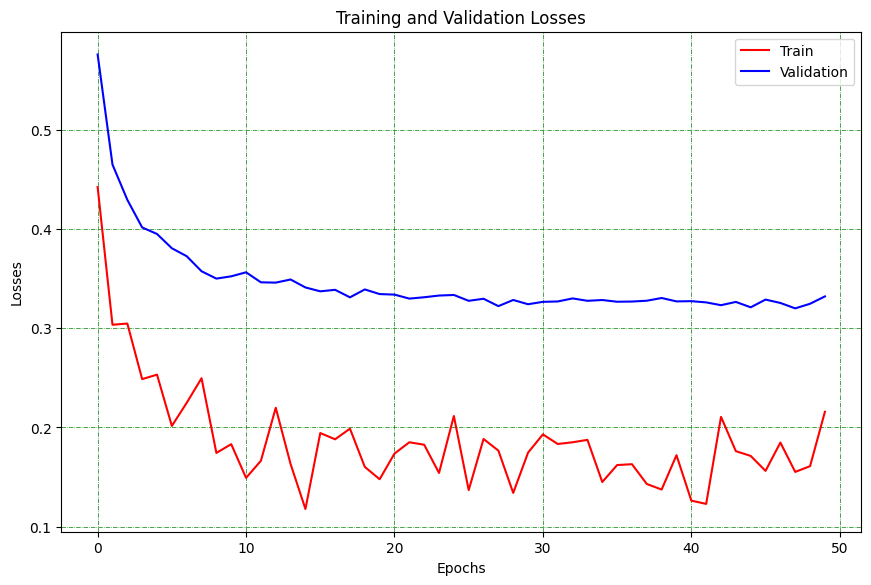

In [42]:
epochs = range(config['num_epoch'])
fig = plt.figure(figsize=(8, 5))
ax = fig.add_axes([0, 0, 1, 1])
ax.plot(epochs, train_losses, color='r', label='Train', alpha=1)
ax.plot(epochs, val_losses, color='b', label='Validation', alpha=1)
ax.grid(color='g', ls='-.', lw=0.5)
ax.set_xlabel('Epochs')
ax.set_ylabel('Losses')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

### Evaluate on the test set
Now we can evaluate on the test set to see how our model perform:

In [44]:
# evaluate on test set
model.eval()
test_sparse_edge_index = test_sparse_edge_index.to(device)
test_edge_index = test_edge_index.to(device)
test_loss, test_recall, test_precision \
    = evaluation(model,
                test_edge_index,
                test_sparse_edge_index,
                [train_edge_index, val_edge_index],
                config['topK'],
                config['lambda'],bpr_loss)


print('Test set: train_loss: {:.4f}, recall: {:.4f}, precision: {:.4f}'\
        .format(test_loss, test_recall, test_precision))


Test set: train_loss: 0.3113, recall: 0.1413, precision: 0.0357


# Make New Recommendatios for a Given User

In [45]:
# helper method to get positive items for train/test sets
def get_positive_items(edge_index):
    """
    Return positive items for all users in form of list
    Parameters:
      edge_index (torch.Tensor): The edge index representing the user-item interactions.
    Returns:
      pos_items (torch.Tensor): A list containing the positive items for all users.
    """
    pos_items = {}
    for i in range(edge_index.shape[1]):
        user = edge_index[0][i].item()
        item = edge_index[1][i].item()
        if user not in pos_items:
            pos_items[user] = []
        pos_items[user].append(item)
    return pos_items



In [46]:
def predict(user_id, topK):
    '''
    Make top K recommendations to the user
    '''
    # read movie and uesr info
    model.eval()
    df = pd.read_csv(movie_path)
    movie_titles = pd.Series(df.title.values, index=df.movieId).to_dict()
    movie_genres = pd.Series(df.genres.values, index=df.movieId).to_dict()
    pos_items = get_positive_items(edge_index)
    user = user_mapping[user_id]
    user_emb = model.users_emb.weight[user]
    scores = model.items_emb.weight @ user_emb

    values, indices = torch.topk(scores, k=len(pos_items[user]) + topK)

    movies = [index.cpu().item() for index in indices if index in pos_items[user]]
    topk_movies = movies[:topK]
    movie_ids = [list(movie_mapping.keys())[list(movie_mapping.values())\
                                            .index(movie)] for movie in movies]
    titles = [movie_titles[id] for id in movie_ids]
    genres = [movie_genres[id] for id in movie_ids]

    print("User {:d} liked these movies:".format(user_id))
    for i in range(topK):
        print("{:s}, {:s} ".format(titles[i], genres[i]))

    print('====================================================================')

    movies = [index.cpu().item() for index in indices if index not in pos_items[user]]
    topk_movies = movies[:topK]
    movie_ids = [list(movie_mapping.keys())[list(movie_mapping.values())\
    .index(movie)] for movie in movies]
    titles = [movie_titles[id] for id in movie_ids]
    genres = [movie_genres[id] for id in movie_ids]

    print("Here are the movies that we think the user will enjoy:")
    for i in range(topK):
        print("{:s}, {:s} ".format(titles[i], genres[i]))


### Try it !
user ID (1 to 943) and the number of movies to recommend

In [47]:
predict(123, 5)

User 123 liked these movies:
Fight Club (1999), Action|Crime|Drama|Thriller 
Shawshank Redemption, The (1994), Crime|Drama 
Silence of the Lambs, The (1991), Crime|Horror|Thriller 
Matrix, The (1999), Action|Sci-Fi|Thriller 
Star Wars: Episode IV - A New Hope (1977), Action|Adventure|Sci-Fi 
Here are the movies that we think the user will enjoy:
Rosemary's Baby (1968), Drama|Horror|Thriller 
Hush (1998), Thriller 
Eternal Sunshine of the Spotless Mind (2004), Drama|Romance|Sci-Fi 
Ex Drummer (2007), Comedy|Crime|Drama|Horror 
Voices of a Distant Star (Hoshi no koe) (2003), Animation|Drama|Romance|Sci-Fi 


In [51]:
movies = pd.read_csv('/content/movies.csv',sep=';',encoding='latin-1').drop('Unnamed: 3',axis=1)
print('Shape of this dataset :',movies.shape)
movies.head()

Shape of this dataset : (3883, 3)


,movieId,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [54]:
!unzip "/content/ratings.csv.zip"
ratings = pd.read_csv('/content/ratings.csv',sep=';')
print('Shape of this dataset :',ratings.shape)
ratings.head()

Archive:  /content/ratings.csv.zip
  inflating: ratings.csv             
Shape of this dataset : (1000209, 4)


,userId,movieId,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [53]:
users = pd.read_csv('/content/users.csv',sep=';')
print('Shape of this dataset :',users.shape)
users.head()

Shape of this dataset : (6040, 5)


,userId,gender,age,occupation,zip-code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,2460
4,5,M,25,20,55455


In [55]:
rating_pivot = ratings.pivot_table(values='rating',columns='userId',index='movieId').fillna(0)
print('Shape of this pivot table :',rating_pivot.shape)
rating_pivot.head()

Shape of this pivot table : (3706, 6040)


userId,1,2,3,4,5,6,7,8,9,10,...,6031,6032,6033,6034,6035,6036,6037,6038,6039,6040
movieId,,,,,,,,,,,,,,,,,,,,,
1,5.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,5.0,5.0,...,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,3.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [56]:
from sklearn.neighbors import NearestNeighbors
nn_algo = NearestNeighbors(metric='cosine')
nn_algo.fit(rating_pivot)

NearestNeighbors(metric='cosine')

In [57]:
class Recommender:
    def __init__(self):
        # This list will stored movies that called atleast ones using recommend_on_movie method
        self.hist = []
        self.ishist = False # Check if history is empty

    # This method will recommend movies based on a movie that passed as the parameter
    def recommend_on_movie(self,movie,n_reccomend = 5):
        self.ishist = True
        movieid = int(movies[movies['title']==movie]['movieId'])
        self.hist.append(movieid)
        distance,neighbors = nn_algo.kneighbors([rating_pivot.loc[movieid]],n_neighbors=n_reccomend+1)
        movieids = [rating_pivot.iloc[i].name for i in neighbors[0]]
        recommeds = [str(movies[movies['movieId']==mid]['title']).split('\n')[0].split('  ')[-1] for mid in movieids if mid not in [movieid]]
        return recommeds[:n_reccomend]

    # This method will recommend movies based on history stored in self.hist list
    def recommend_on_history(self,n_reccomend = 5):
        if self.ishist == False:
            return print('No history found')
        history = np.array([list(rating_pivot.loc[mid]) for mid in self.hist])
        distance,neighbors = nn_algo.kneighbors([np.average(history,axis=0)],n_neighbors=n_reccomend + len(self.hist))
        movieids = [rating_pivot.iloc[i].name for i in neighbors[0]]
        recommeds = [str(movies[movies['movieId']==mid]['title']).split('\n')[0].split('  ')[-1] for mid in movieids if mid not in self.hist]
        return recommeds[:n_reccomend]

In [58]:

# linitializing the Recommender Object
recommender = Recommender()
# Recommendation based on past watched movies, but the object just initialized. So, therefore no history found
recommender.recommend_on_history()
# Recommendation based on this movie
recommender.recommend_on_movie('Father of the Bride Part II (1995)')
# Recommendation based on past watched movies, and this time a movie is there in the history.
recommender.recommend_on_history()

No history found


['Home Alone (1990)',
 'Home Alone 2',
 'Mighty Ducks, The (1992)',
 'Mrs. Doubtfire (1993)',
 'Liar Liar (1997)']

In [59]:
# Recommendation based on this movie
recommender.recommend_on_movie('Tigerland (2000)')
# Recommendation based on past watched movies, and this time two movies is there in the history.
recommender.recommend_on_history()

['Home Alone 2',
 'Home Alone (1990)',
 'Mrs. Doubtfire (1993)',
 'Liar Liar (1997)',
 'Mighty Ducks, The (1992)']

In [60]:
# Recommendation based on this movie
recommender.recommend_on_movie('Dracula')
# Recommendation based on past watched movies, and this time three movies is there in the history.
recommender.recommend_on_history()

['Home Alone 2',
 'Robin Hood',
 'Flintstones, The (1994)',
 'Home Alone (1990)',
 'Multiplicity (1996)']

**Recommendation System using Content Based Filtering**

In [61]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(stop_words='english')
genres = vectorizer.fit_transform(movies.genres).toarray()
contents = pd.DataFrame(genres,columns=vectorizer.get_feature_names_out())
print('Shape of the content table :',contents.shape)
contents.head()

Shape of the content table : (3883, 347)


,1919,1956,1963,1968,1974,1977,1978,1979,1980,1981,...,wight,willowbrook,witch,worrying,wrath,years,yellow,yes,york,yu
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [62]:
from sklearn.neighbors import NearestNeighbors
nn_algo = NearestNeighbors(metric='cosine')
nn_algo.fit(contents)

NearestNeighbors(metric='cosine')

In [63]:
class Recommender:
    def __init__(self):
        # This list will stored movies that called atleast ones using recommend_on_movie method
        self.hist = []
        self.ishist = False # Check if history is empty

    # This method will recommend movies based on a movie that passed as the parameter
    def recommend_on_movie(self,movie,n_reccomend = 5):
        self.ishist = True
        iloc = movies[movies['title']==movie].index[0]
        self.hist.append(iloc)
        distance,neighbors = nn_algo.kneighbors([contents.iloc[iloc]],n_neighbors=n_reccomend+1)
        recommeds = [movies.iloc[i]['title'] for i in neighbors[0] if i not in [iloc]]
        return recommeds[:n_reccomend]

    # This method will recommend movies based on history stored in self.hist list
    def recommend_on_history(self,n_reccomend = 5):
        if self.ishist == False:
            return print('No history found')
        history = np.array([list(contents.iloc[iloc]) for iloc in self.hist])
        distance,neighbors = nn_algo.kneighbors([np.average(history,axis=0)],n_neighbors=n_reccomend + len(self.hist))
        recommeds = [movies.iloc[i]['title'] for i in neighbors[0] if i not in self.hist]
        return recommeds[:n_reccomend]

In [64]:
# linitializing the Recommender Object
recommender = Recommender()
# Recommendation based on past watched movies, but the object just initialized. So, therefore no history found
recommender.recommend_on_history()
print("--------------------------------")
# Recommendation based on this movie
recommender.recommend_on_movie('Father of the Bride Part II (1995)')

No history found
--------------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


['Waiting for Guffman (1996)',
 'Jimmy Hollywood (1994)',
 'Kolya (1996)',
 'Life with Mikey (1993)',
 '8 1/2 Women (1999)']

**Ftom this three method - the most i like it Light GCN. **

**Ref**

1. [Создание рекомендательных систем с использованием библиотеки Surprise
](https://habr.com/ru/companies/otus/articles/764222/)


2. [python-movie-recommender-system](https://github.com/MrPatrek/python-movie-recommender-system)

3. [Creating a Simple Recommender System in Python using Pandas](https://stackabuse.com/creating-a-simple-recommender-system-in-python-using-pandas/)

4. [Movie Recommender Systems with PyG](https://medium.com/stanford-cs224w/movie-recommender-systems-with-pyg-37da71f405a4)